## Imports

In [1]:
import scipy.io
import numpy as np
from sklearn import linear_model 
from scipy import linalg
from sklearn import preprocessing as preproc # load preprocessing function
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
from scipy.stats import linregress
from sklearn.model_selection import KFold
from statsmodels.sandbox.stats.multicomp import multipletests 
import warnings # to silence convergence warnings

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

## Load dataset

In [4]:
mat = scipy.io.loadmat('sand.mat')

X = mat['X']
y = mat['Y']

[n,p] = X.shape

def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu

def normalize(X):
    d = np.linalg.norm(X, ord=2, axis=0)
    return X / d, d



### 2 Find an elastic net solution for the sand data, with suitable choices of regression parameters using cross validation.

>(a) Use the coordinate descent algorithm.

>>(i) Python: Use Python’s `linear_model.ElasticNet`.

>(b) Investigate how different values of α affects the number of nonzero parameters in the coordinate descent algorithms.
  
>(c) What are the pros and cons of the coordinate descent algorithm compared to using LARS?

Text(0.5, 1.0, 'Crossvalidated MSE of Elastic Net Fit Alpha = 0.00')

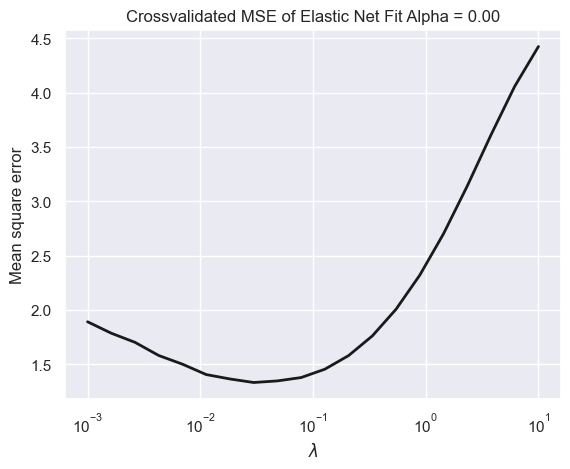

In [8]:
# set up a range of lambdas and an alpha value
alpha = 0.001
lambdas = np.logspace(-3, 1, num=20)

X_norm,_ = centerData(X)
X_norm,_ = normalize(X_norm)
y_norm,_ = centerData(y)

with warnings.catch_warnings(): # done to disable all the convergence warnings from elastic net
    warnings.simplefilter("ignore")

    #Run the elasticNet model. You can implement Crossvalidation yourself or look at ElasticNetCV
    model = linear_model.ElasticNetCV(cv=5, alphas=lambdas, l1_ratio=alpha).fit(X_norm, y_norm)
    
plt.figure()
plt.semilogx(model.alphas_, model.mse_path_.mean(axis=-1), 'k',label='Average across the folds', linewidth=2)
plt.xlabel(r'$\lambda$')
plt.ylabel('Mean square error')
plt.title('Crossvalidated MSE of Elastic Net Fit Alpha = %.2f' % alpha)

Text(0.5, 1.0, 'Sum of coefficients of Elastic Net Fit Alpha = 0.00')

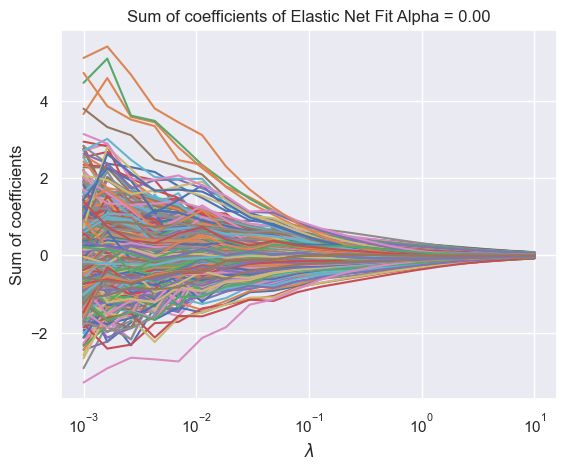

In [14]:
#To look at the coefficients we need to implement CV ourselves
CV = 5
kf = KFold(n_splits=CV, shuffle=True, random_state=42)

coefs = np.zeros((CV,len(lambdas),p))

for i, (train_index, test_index) in enumerate(kf.split(X)):
    #Get training data
    X_train, mu_x = centerData(X[train_index])
    y_train, mu_y = centerData(y[train_index])
    X_test, y_test = X[test_index] - mu_x, y[test_index] - mu_y

    X_train, d = normalize(X_train)
    X_test = X_test / d
    
    for j, lambda_ in enumerate(lambdas):
        with warnings.catch_warnings(): # done to disable all the convergence warnings from elastic net
            warnings.simplefilter("ignore")

            #Run the elasticNet model.
            model = linear_model.ElasticNet(alpha=lambda_, l1_ratio=alpha).fit(X_train, y_train)
            coefs[i,j,:] = model.coef_
        
trace = np.sum(coefs, axis=0)

plt.figure()
plt.semilogx(lambdas, trace)
plt.xlabel(r'$\lambda$')
plt.ylabel('Sum of coefficients')
plt.title('Sum of coefficients of Elastic Net Fit Alpha = %.2f' % alpha)